# SegNet for Stone Segmentation

This notebook demonstrates how to implement and train a **SegNet** model for stone segmentation. We will:

1. Import dependencies.
2. Load images and masks from the augmented dataset.
3. Build a custom data generator (or simple loader) to feed images/masks to the model.
4. Define a SegNet model using TensorFlow/Keras.
5. Train and evaluate the model.

We will place this notebook as `segnet_chambord.ipynb` inside `notebooks/`. The paths to images and masks will be:
- `../data/annotations/augmented/images`
- `../data/annotations/augmented/masks`


## SegNet
SegNet is a deep convolutional encoder-decoder architecture for semantic pixel-wise segmentation. It uses an encoder to down-sample and a corresponding decoder that up-samples using pooling indices (in the original paper). Here, we'll implement a simplified version of SegNet without argmax-based unpooling, but the idea remains similar.

In [1]:
# !pip install tensorflow

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("scikit-learn version:", tf.__version__)

TensorFlow version: 2.16.2
Keras version: 3.9.0
scikit-learn version: 2.16.2


## Hyperparameters and Paths

In [2]:
# Define directories for images and masks
IMAGES_DIR = "../data/augmented/images"
MASKS_DIR = "../data/augmented/masks"

# Image details
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
NUM_CLASSES = 2  # we have 2 classes: background and stones (black and white)

# Training parameters
BATCH_SIZE = 4
EPOCHS = 100  
VAL_SPLIT = 0.2  # 20% of data for validation

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1. Loading and Splitting the Dataset

- The `images` folder contains all the input images.
- The `masks` folder contains the corresponding masks with the **same filename** (`image_001.png` to `image_00n.png`)

We'll gather the filenames, split into train/validation sets, and create a simple Python generator to load them in batches.

In [3]:
def load_image(image_path, target_size=(256, 256), grayscale=False):
    """
    Loads an image from disk, resizes it, and converts it to an array.
    Optionally loads in grayscale (useful for masks).
    """
    img = load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img_array = img_to_array(img)
    return img_array

image_filenames = sorted(os.listdir(IMAGES_DIR))

# Build full paths
image_paths = [os.path.join(IMAGES_DIR, f) for f in image_filenames]
mask_paths = [os.path.join(MASKS_DIR, f) for f in image_filenames]  # assume same filenames

print("Total images found:", len(image_paths))

Total images found: 4000


### Train/Validation Split

In [4]:
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=VAL_SPLIT, random_state=SEED
)

print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))

Training set size: 3200
Validation set size: 800


## 2. Data Generator
We will define a simple generator that:
- Takes a list of image paths and mask paths.
- Yields batches of `(image_batch, mask_batch)`.
- Rescales images to [0,1].
- Optionally one-hot encodes the masks if we have multiple classes.

> For **binary segmentation** (2 classes), we store masks in a single channel (0 or 1). For **multi-class** segmentation, we store integer labels per pixel and then one-hot encode them.

In [5]:
def data_generator(image_paths, mask_paths, batch_size, num_classes, input_size=(256,256)):
    """
    Yields batches of (images, masks) for training/validation.
    """
    while True:
        # Shuffle at the beginning of each epoch
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_indices = indices[start:end]

            images = []
            masks = []

            for i in batch_indices:
                img = load_image(image_paths[i], target_size=input_size, grayscale=False)
                mask = load_image(mask_paths[i], target_size=input_size, grayscale=True)

                # Scale images to [0,1]
                img = img / 255.0
                mask = mask / 255.0  # For binary, this will be 0 or 1

                # 3. Invert the mask
                #    (i.e., if currently stones are black and joints are white).
                #    This flips 0 -> 1 and 1 -> 0.
                mask = 1.0 - mask

                # For binary segmentation, we can keep mask as shape (H, W, 1)
                # If multiple classes, convert to one-hot: e.g. tf.one_hot()
                if num_classes > 2:
                    # Squeeze channel -> shape (H, W)
                    mask = np.squeeze(mask, axis=-1)
                    # Convert to int in case of float rounding
                    mask = mask.astype(np.uint8)
                    # One-hot encode
                    mask = tf.one_hot(mask, num_classes)
                    mask = tf.reshape(mask, (input_size[0], input_size[1], num_classes))
                    mask = mask.numpy()
                else:
                    # Binary case: keep single channel with values 0 or 1
                    # ensure 0/1 by thresholding 
                    mask = (mask > 0.5).astype(np.float32)  # shape (H, W, 1)
                    

                images.append(img)
                masks.append(mask)

            images = np.array(images, dtype=np.float32)
            masks = np.array(masks, dtype=np.float32)

            yield images, masks

## 3. Defining the SegNet Model
Below is a simplified version of the SegNet architecture using Keras. We use standard `Conv2D`, `BatchNormalization`, and `MaxPooling2D` for the encoder, then mirror it with `Conv2DTranspose` and `Conv2D` in the decoder.

> **Note**: The original SegNet uses argmax indices to unpool. Here, we use simpler `UpSampling2D` or `Conv2DTranspose` for demonstration.


In [6]:
def segnet(input_shape=(256, 256, 3), num_classes=2):
    """
    A simplified SegNet architecture.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Final layer
    # For multi-class, we use 'num_classes' filters and softmax activation.
    # For binary, we can use 1 filter with sigmoid activation.
    if num_classes == 2:
        # binary segmentation
        x = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)
    else:
        # multi-class segmentation
        x = layers.Conv2D(num_classes, (1,1), padding='same', activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

# Instantiate the model
model = segnet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

2025-03-14 18:19:28.528136: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-14 18:19:28.528163: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-14 18:19:28.528167: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-14 18:19:28.528181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-14 18:19:28.528192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             

 Total params: 2,109,761 (8.05 MB)

 Trainable params: 2,107,073 (8.04 MB)

 Non-trainable params: 2,688 (10.50 KB)

## 4. Compile and Train the Model
- For **binary segmentation** (`NUM_CLASSES = 2`), we can use `loss='binary_crossentropy'`.
- For **multi-class** segmentation, we can use `loss='categorical_crossentropy'`.
- We will use the Adam optimizer. We can experiment with learning rates.


In [7]:
# Decide whether we want to train from scratch or skip training
SKIP_TRAINING = True  # False if we want to retrain

if not SKIP_TRAINING:
    # Training code
    if NUM_CLASSES == 2:
        loss = 'binary_crossentropy'
        final_activation = 'sigmoid'
    else:
        loss = 'categorical_crossentropy'
        final_activation = 'softmax'

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=loss,
        metrics=["accuracy"]
    )

    # Create generators
    train_gen = data_generator(
        train_images,
        train_masks,
        BATCH_SIZE,
        NUM_CLASSES,
        input_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
    )

    val_gen = data_generator(
        val_images,
        val_masks,
        BATCH_SIZE,
        NUM_CLASSES,
        input_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
    )

    # Calculate steps per epoch
    train_steps = len(train_images) // BATCH_SIZE
    val_steps = len(val_images) // BATCH_SIZE

    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_data=val_gen,
        validation_steps=val_steps,
        verbose=1
    )
else:
    # --- Loading the model instead of training ---
    from tensorflow.keras.models import load_model
    model = load_model("../models/segnet_chambord.keras", compile=False)
    print("Model loaded from disk. Training skipped.")


Model loaded from disk. Training skipped.


## 5. Visualize Training Curves
We can plot the training and validation loss/accuracy to see how the model evolves.

In [9]:
plt.figure(figsize=(12,4))
if 'history' in globals():
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
else:
    print("Training was skipped, so no training history available for plotting.")


Training was skipped, so no training history available for plotting.


<Figure size 1200x400 with 0 Axes>

## 6. Sample Prediction
Let's visualize how the model performs on a few validation samples.

2025-03-14 18:23:09.892088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


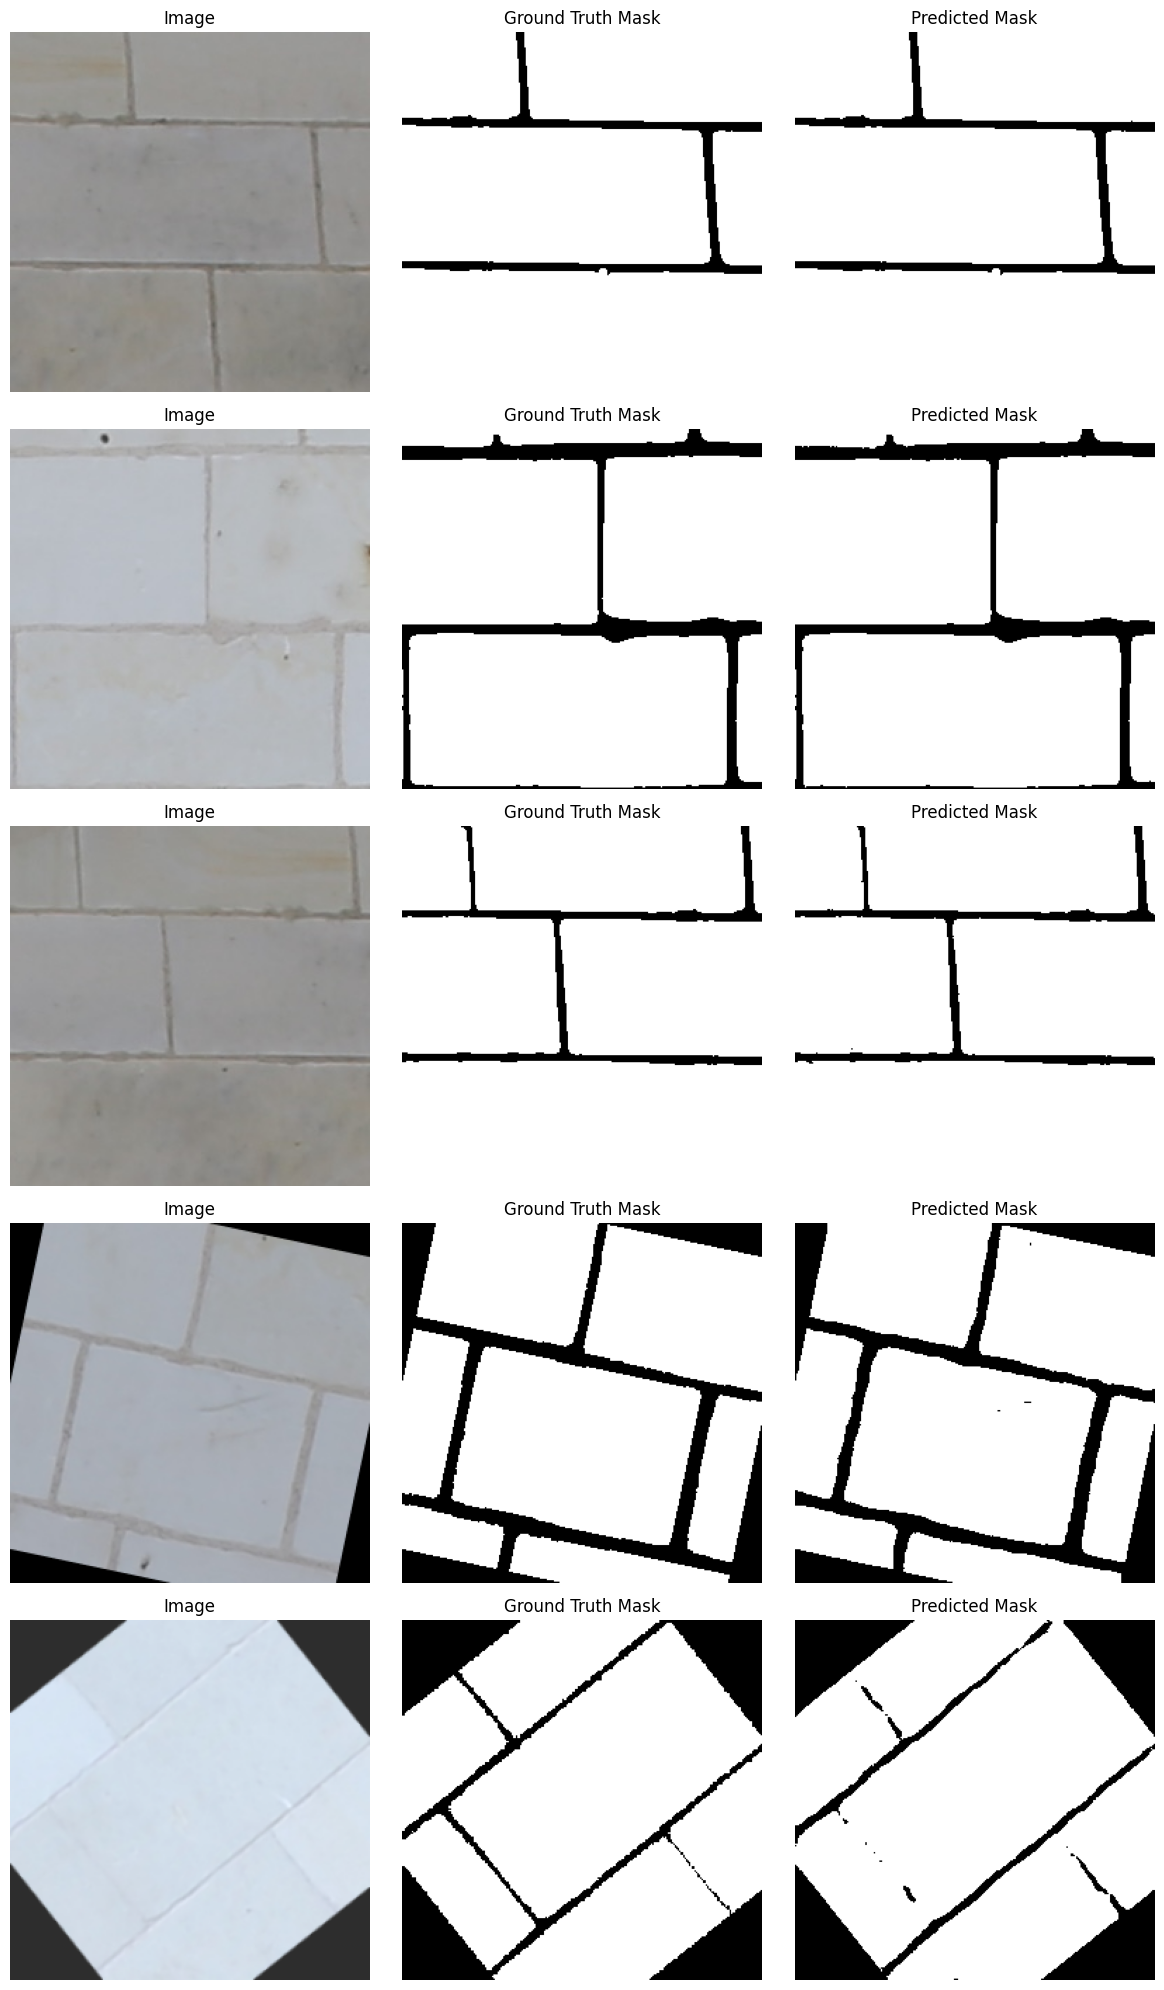

In [10]:
def visualize_predictions(model, image_paths, mask_paths, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_samples=3):
    # To ensure we don't exceed the available samples
    num_samples = min(num_samples, len(image_paths))
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    # If only a single sample is provided, wrap axs into a list
    if num_samples == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i in range(num_samples):
        # Load and preprocess image/mask
        img = load_image(image_paths[i], target_size=input_size, grayscale=False)
        mask = load_image(mask_paths[i], target_size=input_size, grayscale=True)
        img_scaled = img / 255.0
        mask_scaled = mask / 255.0
        
        # Expand dims and predict
        pred = model.predict(np.expand_dims(img_scaled, axis=0))
        if NUM_CLASSES == 2:
            pred_mask = (pred[0, :, :, 0] > 0.5).astype(np.uint8)
        else:
            pred_mask = np.argmax(pred[0], axis=-1)
        
        # Plot image, ground truth, and prediction
        axs[i, 0].imshow(img.astype(np.uint8))
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(mask_scaled[:, :, 0], cmap='gray')
        axs[i, 1].set_title('Ground Truth Mask')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage: we can visualize 5 samples from the validation set.
visualize_predictions(model, val_images, val_masks, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_samples=5)


## 7. Saving the Model
Save the trained model to the `models/` directory so we can reuse it.

In [11]:
if not SKIP_TRAINING:
    SAVE_PATH = "../models/segnet_chambord.keras"
    model.save(SAVE_PATH)
    print(f"Model saved to {SAVE_PATH}")
else:
    print("Model not saved, as training was skipped.")

Model not saved, as training was skipped.


## 8. Post-Training Evaluation: Compute IoU and Dice Metrics


In [12]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm  # Progress bar

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Hide TF warnings/info
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow logging


#  Define functions to compute IoU and Dice Coefficient 

def compute_iou(y_true, y_pred):
    """
    Compute the Intersection over Union (IoU) for binary masks.
    
    Parameters:
      y_true: Ground truth mask (shape: [batch, height, width, 1]).
      y_pred: Predicted mask (shape: [batch, height, width, 1]), assumed to be binary.
    
    Returns:
      IoU score as a float.
    """
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Compute intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Avoid division by zero
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.numpy()

def compute_dice(y_true, y_pred):
    """
    Compute the Dice Coefficient for binary masks.
    
    Parameters:
      y_true: Ground truth mask (shape: [batch, height, width, 1]).
      y_pred: Predicted mask (shape: [batch, height, width, 1]), assumed to be binary.
    
    Returns:
      Dice Coefficient as a float.
    """
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Compute intersection and denominator
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2.0 * intersection + 1e-7) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7)
    return dice.numpy()

# Compute IoU and Dice metrics for the entire validation set

iou_scores = []
dice_scores = []

# Loop through each validation sample using your previously defined lists: val_images and val_masks.
for img_path, mask_path in zip(val_images, val_masks):
    # Load and preprocess the image and mask
    img = load_image(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), grayscale=False)
    mask = load_image(mask_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), grayscale=True)
    
    # Normalize to [0,1]
    img = img / 255.0
    mask = mask / 255.0  # Binary mask: values are 0 or 1
    
    # Predict the mask with the trained model (expand dims to add batch dimension)
    pred = model.predict(np.expand_dims(img, axis=0))
    
    # Binarize prediction using threshold 0.5 (for binary segmentation)
    pred_bin = (pred[0, :, :, 0] > 0.5).astype(np.float32)
    
    # Ensure shapes are (H, W, 1)
    pred_bin = np.expand_dims(pred_bin, axis=-1)
    mask = np.expand_dims(mask[:, :, 0], axis=-1)
    
    # Compute metrics for the current sample
    # Expand dims to simulate a batch of size 1
    current_iou = compute_iou(mask[np.newaxis, ...], pred_bin[np.newaxis, ...])
    current_dice = compute_dice(mask[np.newaxis, ...], pred_bin[np.newaxis, ...])
    
    iou_scores.append(current_iou)
    dice_scores.append(current_dice)

# Calculate the mean metrics across all validation samples
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)

print("Validation Mean IoU: {:.4f}".format(mean_iou))
print("Validation Mean Dice: {:.4f}".format(mean_dice))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━

In [13]:
# Evaluate on External Test Set

import os
import numpy as np
import tensorflow as tf

# Paths to test images and their GT masks
TEST_IMAGES_DIR = "../test/images"
TEST_GT_DIR = "../test/gt"

test_image_filenames = sorted(os.listdir(TEST_IMAGES_DIR))
test_mask_filenames = sorted(os.listdir(TEST_GT_DIR))

# We'll store IoU and Dice for each test image
test_iou_scores = []
test_dice_scores = []

# we assume the test images and GT masks have the same filenames
# Check if the number of test images and GT masks match
assert len(test_image_filenames) == len(test_mask_filenames), \
       "Mismatch between number of test images and ground truth masks!"

for img_fname, gt_fname in zip(test_image_filenames, test_mask_filenames):
    #  Load the test image (RGB) and ground truth mask (grayscale)
    img_path = os.path.join(TEST_IMAGES_DIR, img_fname)
    gt_path = os.path.join(TEST_GT_DIR, gt_fname)
    
    img = load_image(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), grayscale=False)
    gt_mask = load_image(gt_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), grayscale=True)
    
    # 2. Normalize to [0,1]
    img = img / 255.0
    gt_mask = gt_mask / 255.0  # currently stones=0, joints=1 in the GT folder

    # Invert the ground truth so that stones=1, joints=0
    #    because the model predicts stones=1, joints=0
    gt_mask_inverted = 1.0 - gt_mask
    
    # Predict using our trained model
    pred = model.predict(np.expand_dims(img, axis=0))  # shape: (1, H, W, 1)
    
    # 5. Binarize prediction at threshold=0.5
    pred_bin = (pred[0, :, :, 0] > 0.5).astype(np.float32)
    pred_bin = np.expand_dims(pred_bin, axis=-1)  # shape: (H, W, 1)
    
    # Evaluate IoU & Dice
    #    We'll reuse existing compute_iou / compute_dice functions
    #    but we must pass arrays shaped like (1, H, W, 1) to match the batch dimension.
    current_iou = compute_iou(gt_mask_inverted[np.newaxis, ...], pred_bin[np.newaxis, ...])
    current_dice = compute_dice(gt_mask_inverted[np.newaxis, ...], pred_bin[np.newaxis, ...])
    
    test_iou_scores.append(current_iou)
    test_dice_scores.append(current_dice)

# Compute mean IoU & Dice across all test images
mean_test_iou = np.mean(test_iou_scores)
mean_test_dice = np.mean(test_dice_scores)

print(f"Test Mean IoU:  {mean_test_iou:.4f}")

print(f"Test Mean Dice: {mean_test_dice:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [14]:
import os
import numpy as np
from PIL import Image

SAVE_MASKS_DIR = "../predicted_images/segnet_masks"
os.makedirs(SAVE_MASKS_DIR, exist_ok=True)

num_samples_to_save = 10

for i, (img_fname, gt_fname) in enumerate(zip(test_image_filenames, test_mask_filenames)):
    if i >= num_samples_to_save:
        break

    img_path = os.path.join(TEST_IMAGES_DIR, img_fname)
    
    # 1) Load & normalize
    img = load_image(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), grayscale=False)
    img = img / 255.0
    
    # 2) Predict
    pred = model.predict(np.expand_dims(img, axis=0))
    
    # 3) Binarize
    pred_mask = (pred[0, :, :, 0] > 0.5).astype(np.uint8)  # shape: (H, W)
    
    # 4) Scale to [0..255]
    pred_mask_255 = (pred_mask * 255).astype(np.uint8)
    
    # 5) Expand to 3-channel so black= [0,0,0], white= [255,255,255]
    rgb_array = np.stack([pred_mask_255]*3, axis=-1)  # shape: (H, W, 3)

    # 6) Convert to a Pillow image in RGB mode
    mask_img = Image.fromarray(rgb_array, 'RGB')
    
    # 7) Save as JPEG (which has no alpha channel)
    base_name = os.path.splitext(img_fname)[0]
    save_name = f"pred_{base_name}.jpg"
    save_path = os.path.join(SAVE_MASKS_DIR, save_name)
    mask_img.save(save_path, format="JPEG", quality=100)
    
    print(f"Saved predicted mask for {img_fname} as {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Saved predicted mask for 01459.png as ../predicted_images/segnet_masks/pred_01459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Saved predicted mask for 01460.png as ../predicted_images/segnet_masks/pred_01460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Saved predicted mask for 01461.png as ../predicted_images/segnet_masks/pred_01461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Saved predicted mask for 01462.png as ../predicted_images/segnet_masks/pred_01462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Saved predicted mask for 01463.png as ../predicted_images/segnet_masks/pred_01463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Saved predicted mask for 01464.png as ../predicted_images/segnet_masks/pred_01464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Saved predicted mask for 01465.png as ../predicted_images/segnet_masks/pred_01465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Saved predicted mask for 01466.png as ../predicted_images/segnet_masks/pred_01466.jpg
1/1 ━━━

## 9. Conclusion

This study presented the development and evaluation of a SegNet model for stone segmentation. The model is configured to predict pixel-level masks with stones represented as white (1) and joints as black (0). A custom data generator was implemented to load an augmented dataset for training and validation, and the model was trained using the Adam optimizer and binary crossentropy loss.

### Validation Performance
- **Mean Intersection over Union (IoU)**: 0.9892  
  
- **Mean Dice Coefficient**: 0.9945  

These metrics indicate that, on the validation set, the predicted masks exhibit a very high overlap and similarity with the ground truth, suggesting that the model effectively captures the essential features for stone segmentation.

### Test Set Evaluation
For further evaluation, the model was applied to an independent test set. In this test set, the expert-provided ground truth masks use the inverse labeling convention (stones as black, joints as white). To enable a fair comparison, the ground truth masks were inverted using `gt_mask_inverted = 1.0 - gt_mask` so that their labeling aligns with the model’s predictions. The performance on the test set was as follows:

- **Mean Intersection over Union (IoU)**: 0.9176  
  
- **Mean Dice Coefficient**: 0.9555  

Although the test set performance is slightly lower than that of the validation set, the high IoU and Dice coefficients demonstrate robust segmentation capability. The differences in performance may be due to variations in data distribution or labeling differences between the augmented training data and the expert-annotated test set.

### Summary
- **Model Development**: A SegNet architecture was successfully implemented and trained for stone segmentation.
  
- **Validation Results**: The model achieved near-perfect segmentation on the validation set.
  
- **Test Evaluation**: After inverting the expert-provided ground truth masks, the model maintained high performance on the test set.
  
- **Implications**: The results support the efficacy of the SegNet model for this application and provide a foundation for further comparative studies with alternative segmentation methods.

Overall, the findings suggest that the implemented SegNet model is effective for stone segmentation.
